<h1>Dynamic Programming: Value Iteration (Synchronous)</h1>

<h2>Gridworld Example</h2>

Dynamic programming can be used to find an optimal policy $\pi_*$ to guide an agent along the shortest path from any square in the maze to the finish line square.

This notebook contains a solution to the Gridworld poblem using [Value Iteration](#value-iteration) methods.

The Gridworld experiment described in this notebook makes the following asssumptions:
1. The environment has a fully specified model of its transition probabilities which can be accessed by the agent.

2. The maze is constructed from a grid whose size (i.e. number of states) is small enough to allow the agent to sweep through the state-space within a relatively short period of time.

<h2>Environment: Gridwolrd</h2>


The Gridwolrd environemnt is composed of a class containing the maze itself, the possible actions allowed within the environment and helpoer functions to compute rewards and transition probabilties of the possible moves available. See the [Gridworld environment class notebook](envGridworld.ipynb) for details of this class. 

<center><img src="images\gridworld_grid.png"/></center>

<h3>Environment Gridworld: Maze</h3>

The maze is represented as a 20x20 numpy array of integers where each elelment of the 2D array represents a position in the maze and the value of each element signifies whether the position can be occupied by the agent or if the position is a wall.

$$
\large maze[i,j]
= 
\begin{cases}
0\quad\quad \,\,\,\,\,\,maze[i,j]\normalsize\text{ is not a wall } \\
-1\quad\,\,\,\,\,\,\,\,maze[i,j]\normalsize\text{ is a wall}
\end{cases}
$$

<h3>Environment Gridworld: States</h3>

Each white square in the maze represents a state which is a random variable which we denote as $S$.<br> 

Each observed state $s\in S$ is defined as an ordered pair $(x,y)$ which represents the position of the agent on the grid.

$$\large S\coloneqq\{(x, y): (x\in\mathbb{Z}) \cap (0\le x<n) \bigcap (y\in\mathbb{Z}) \cap (0\le y<m)\}$$

<h3>Environment Gridworld: States</h3>

Each action is a random variable which we denote with the symbol $A$ and there are four actions available to the agent.<br>
$$\large A\coloneqq\{Up, Down, Left, Right\}$$

<h3>Environment Gridworld: Rewards</h3>

At each time step the reward of an action taken is either -1 or 0 depending upon whether the next state is a finish line or non-finish line square on the grid. 

$$
\large R_t
= 
\begin{cases}
0\quad\quad \Large s_{t+1}\normalsize =\text{ finish line square on the grid } \\
-1\quad\, \Large s_{t+1}\normalsize\neq\text{ finish line square on the grid}
\end{cases}
$$

<h3>Environment Gridworld: Transitions</h3>

The transition probabilities used by the Gridwold environment assume that the probability of moving to the next state (i.e. square in the maze) given any any action $a \in A$ from any current state $s \in S$ is equal to 1. More simply there is only one possible next state $s' \in S$ for each action $a \in A$.

$$\large P(S_{t+1}=s_{t+1}|S_t=s_t, A=a_t) = 1 \qquad \forall \,s_{t+1}, s_t \in S,\, a_t \in A$$

<h2>Policy</h2>

Our agent's policy is denoted as $\pi$ and is used to represent the conditional probability mass function $f_{A|S}$ of actions over the states:<br>
$$\large \pi\coloneqq f_{A|S}$$

At any given timestep $t$, our agent must choose an action $a\in A$ to move from its current state $s\in S$ to its next state $s'\in S$.

We denote the conditional probability of our agent selecting action $a\in A$ given its current state $s\in S$ by the following notation:
$$\large \pi(a|s)=f_{A|S}(a|s)=P(A=a|S=s)$$



A policy used in Gridworld is represented by an $mxnx|S|$ numpy array pi where each element represents the probability of taking action $a\in A$ while in the state $s=(i,j)$

As an example a random policy, example_pi, for taking actions $A$ with equal probability in a $2x2$ maze would have the shape (2,2,4).

In [1]:
import numpy as np

In [2]:
example_pi = np.zeros((2,2,4),dtype=np.float32)
example_pi[:] = 0.25
print(example_pi)
example_pi.shape

[[[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]]


(2, 2, 4)

<h2>State Value Function</h2>

An $mxn$ matrix $V$ is used to store the values of each state $v_\pi(s)$ on the grid where, according to the Bellman equations, the state value represents the expected return of the current state while folowing policy $\pi.\,\,$[\[1\]](#References)<br>


$\large\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad v_\pi(s_t) \coloneqq \mathbb{E} [G_t | S_t=s_t]$<br>
$\large\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad= \mathbb{E} [R_{t+1} + \gamma G_{t+1} | S_t=s_t]$<br>
$\large\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad=\mathbb{E} [R_{t+1} + \gamma v_\pi (S_{t+1}) | S_t=s_t] $<br>
$\large\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad=\sum\limits_{a} \pi(a|s_t) \sum\limits_{s_{t+1}} \sum\limits_{r} p(s_{t+1}, r| s_t, a)[r+\gamma v_\pi(s_{t+1})] $


As an example the 2D numpy array V for a maze of shape $2x2$ represents the state value $v_\pi(s)$ for each $s\in S$ and would have the shape (2,2).

In [3]:
example_V = np.random.sample((2,2))
print(example_V)
example_V.shape

[[0.78111108 0.96387443]
 [0.37303114 0.52380938]]


(2, 2)

<a id="value-iteration"></a>

<h2>Value Iteration</h2>


The Value Iteration algorithm turns the Bellman optimality eqution into an update rule.[\[2\]](#References)

$\large\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad v_{k+1}(s_t) \coloneqq \underset{a}{\operatorname{\max}}\,\,\mathbb{E} [R_{t+1} + \gamma v_k(S_{t+1}) | S_t=s_t] $<br>

$\large\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad=\underset{a}{\operatorname{\max}}\,\, \sum\limits_{s_{t+1}} \sum\limits_{r} p(s_{t+1}, r| s_t, a)[r+\gamma v_k(s_{t+1})] $


In contrast to the [Policy Iteration](dynamic_programming_sync_policy_iteration_gridworld.ipynb) alorithm, which involves a policy evaluation step during each iteration, the Value Iteration algorithm performs one policy improvement step at the very end after $v_*(s)$ has been estimated for all $s\in s$. [\[2\]](#References)

<h2>Value Iteration Algorithm</h2>

$\large\quad\quad\text{Value Iteration Algorithm: valueIteration}$<br>
$\large\quad\quad\text{Inputs:}\,\,environment,\,\,\gamma\,\,\,tolerance$<br>

$\large\quad\quad\text{1.}\quad V\leftarrow \text{random }m\,x\,n \text{ matrix where }V\text{(finish-line\,state)=0}$<br>
$\large\quad\quad\text{2.}\quad \pi\leftarrow m\,x\,n\,x\,|A|\text{ matrix where}\,\,\pi[i,j,a]=0.25\,\,\forall\,i,j,a$<br>
$\large\quad\quad\text{3.}\quad\,\delta \leftarrow \infty$<br>
$\large\quad\quad\text{4.}\quad\text{Loop while}\,\delta > tolerance$:<br>
$\large\quad\quad\text{5.}\quad\quad\,\delta \leftarrow 0$<br>
$\large\quad\quad\text{6.}\quad\quad\text{Loop over all states }s\in S:$<br>
$\large\quad\quad\text{\#}\quad\quad\quad V(s)\leftarrow \underset{a}{\operatorname{\max}} \sum\limits_{s_{t+1}}\sum\limits_{r} P(s_{t+1},\,r|s_t,\,a)[r + \gamma\,V(s_{t+1})]$<br>
$\large\quad\quad\text{7.}\quad\quad\quad V(s)\leftarrow\text{bellmanOptimalityUpdate}(maze,\,V,\,\gamma,\,tolerance)$<br>
$\large\quad\quad\text{8.}\quad\quad\quad\delta \leftarrow max(\delta, |v-V(s)|)$<br>
$\large\quad\quad\text{9.}\quad\text{Loop over all states }s\in S:$<br>
$\large\quad\quad\text{\#}\quad\quad\pi(a|s_t)\leftarrow \underset{a}{\operatorname{\arg\max}} \sum\limits_{s_{t+1}}\sum\limits_{r} P(s_{t+1},\,r|s_t,\,a)[r + \gamma\,V(s_{t+1})]$<br>
$\large\quad\quad\text{10.}\quad\,\,\,\pi(a|s_t)\leftarrow\,\,qGreedifyPolicy(environment,\,\,V,\,\,s_t,\,\,\gamma)$<br>
$\large\quad\quad\text{11.}\,\,\, \text{Return}\,V,\,\pi$<br>


In [4]:
# 10. Helper function to perform a greedy update of the policy (see #10 in the psuedocode above)
def qGreedifyPolicy(environment, V, state, gamma):
    i, j = state
    max_sum_sp_r = (float)("-inf")
    arg_max = []
    for a in environment.Actions:
        if (a == "up"):
            a = 0                    
        if (a == "down"):
            a = 1
        if (a == "left"):
            a = 2
        if (a == "right"):
            a = 3

        sum_sp_r = 0
        (i_next, j_next), r, p = environment.transitions(state=state, action=a)
        sum_sp_r +=  p * (r + gamma * V[i_next, j_next])
        
        if (sum_sp_r > max_sum_sp_r):
            max_sum_sp_r = sum_sp_r
            arg_max = []
        if (sum_sp_r == max_sum_sp_r):
            arg_max.append(a)

    pi_a_given_s = np.zeros((4,))
    
    # greedify to create a deterministic policy for this state using random tie breaks
    for k in np.arange(4):
        if (k in arg_max):
            pi_a_given_s[k] = 1.0 / len(arg_max)

    return pi_a_given_s

In [5]:
# 7. Helper function to update V(s) using Bellman optimality equation 
def bellmanOptimalityUpdate(environment, V, state, gamma):
    i, j = state
    max_sum_sp_r = (float)("-inf")
    for a in environment.Actions:
        if (a == "up"):
            a = 0                    
        if (a == "down"):
            a = 1
        if (a == "left"):
            a = 2
        if (a == "right"):
            a = 3

        sum_sp_r = 0
        (i_next, j_next), r, p = environment.transitions(state=state, action=a)
        sum_sp_r +=  p * (r + gamma * V[i_next, j_next])
        
        if (sum_sp_r > max_sum_sp_r):
            max_sum_sp_r = sum_sp_r

    V[state[0], state[1]] = max_sum_sp_r
    return V[state[0], state[1]]

In [6]:
def valueIteration(environment, gamma, tolerance):
    # 1. Initialize V(s) to random float for all states 
    V = 5 * np.random.sample((environment.Maze.shape[0], environment.Maze.shape[1]))
    for i in range(environment.Maze.shape[0]):
        for j in range(environment.Maze.shape[1]):
            if (environment.Maze[i,j] == -1):
                V[i,j] = (float)('-inf')
                continue
            if (i == environment.finish_position[0] and j == environment.finish_position[1]):
                V[i,j] = 0

    # 2. Initialize pi(s) to equal probabilities 0.25 for all s in S
    pi = np.zeros((environment.Maze.shape[0], environment.Maze.shape[1], len(environment.Actions))) / len(environment.Actions)
    pi[:,:,:] = 0.25
    
    count = 0
    # 3. Initialize delta to infinity
    delta = (float)('inf')
    # 4. Loop while delta > tolerance
    while(delta > tolerance):
        # 5. Set delta to zero
        delta = 0
        # 6. Looop over all states s in S
        for i in np.arange(environment.Maze.shape[0]):
            for j in np.arange(environment.Maze.shape[1]):
                if (environment.Maze[i,j] == -1):
                    continue
                state = tuple(environment.States[i,j])
                v = V[i, j].copy()
                # 7. Set V(s) to using Bellman optimality equation
                V[i,j] = bellmanOptimalityUpdate(environment=environment, V=V, state=state, gamma=gamma)
                # 8. delta = maz(delta, abs(v-V[i,j])
                delta = max(delta, abs(v- V[i,j]))
        count = count+1
    # 9. Loop over all states in S
    for i in np.arange(environment.Maze.shape[0]):
        for j in np.arange(environment.Maze.shape[1]):
            if (environment.Maze[i,j] == -1):
                continue
            state = tuple(environment.States[i,j])
            # 10. Greedify the policy for state s using V
            pi[i,j] = qGreedifyPolicy(environment=environment, V=V, state=state, gamma=gamma)
    path_to_policy_fig = h.plotValuesPolicy(values=V, pi=pi, count=count, mask=environment.Mask, type='value_iteration')
    # 11. return optimal state values V and optimal policy pi
    return V, pi, path_to_policy_fig

<h2>Perform Value Iteration Algorithm On The Gridworld Environment</h2>

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as mpimg
from IPython.display import Image
import seaborn as sns
import import_ipynb
import ipynb.fs.full.envGridworld as gw
import ipynb.fs.full.helpers as h

In [8]:
# Set the discount factor gamma for rewards
gamma = 0.99

# Set a tolerance for comparison of updated state values for policy evaluation
tolerance = 0.0000000001

# Select a square in the Gridworld maze to act as the finish line square
finish_position = (0,19)

An environment can be instantiated by simply choosing a finish position and then calling the envGridworld constructor which takes a path to a numpy array representing the maze and the selected finishing square position as a tuple.

In [9]:
# Instantiate a Gridworld environment
gridworld = gw.envGridworld(path_to_maze="./maze.npy", finish_position=finish_position)

Now run the valueIteration algorithm on the Gridworld environmnet object using $\gamma$ and tolerance parameters set above.

In [10]:
v_star, pi_star, path_to_policy_fig = valueIteration(environment=gridworld, gamma=gamma, tolerance=tolerance)

<h2>Policy Iteration Results for Gridworld</h2>

The resulting optimal policy and state values are provided in the figure below. Each square in the grid contains:
1. the next action (or set of actions) provided by the optimal policy $\pi_*$<br>
2. the optimal state value $v_*(s_t)$ for the position on the grid.

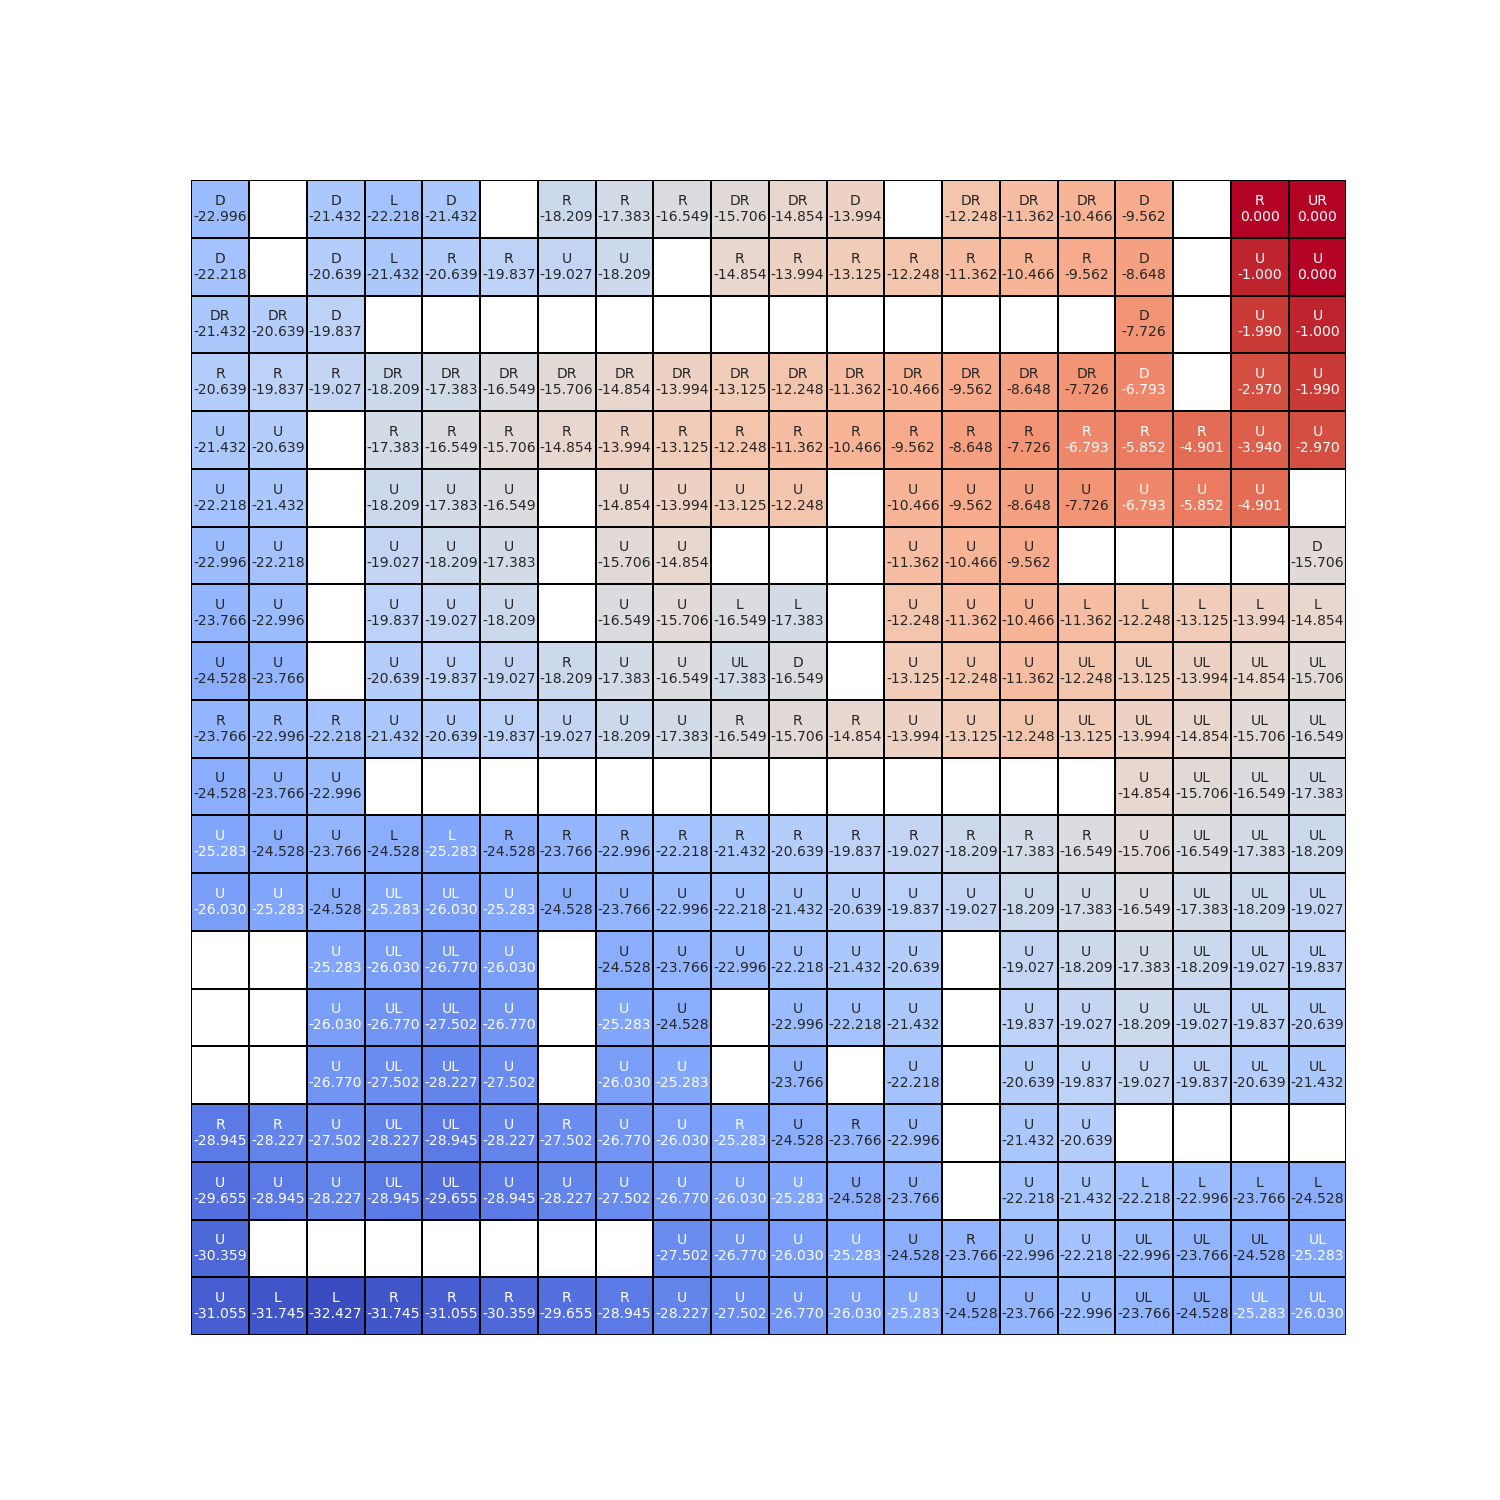

In [11]:
Image(filename=path_to_policy_fig)

<h2>References</h2>

[1] Sutton R.S., Barto A.G., "Reinforcement Learning, An Introduction", 2nd ed, MIT Press, Cambridge MA, 2018, p. 59.<br>
[2] Sutton R.S., Barto A.G., "Reinforcement Learning, An Introduction", 2nd ed, MIT Press, Cambridge MA, 2018, p. 83.<br>